In [2]:
import torch
import torch.nn.functional as F
from torch_scatter import scatter_add
from torch_sparse import coalesce

from torch.nn import PairwiseDistance
from torch import sigmoid as sigmoid
from torch import tanh as tanh
from torch import softmax as softmax
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import torch_geometric.utils as U
from torch_geometric.data import Data

import networkx as nx
from cluster import *
import sys
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
from shapes import *
from build_structure import *

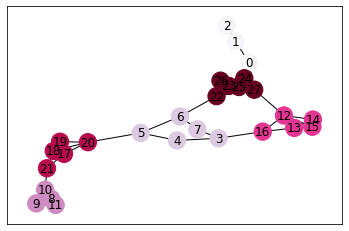

In [3]:
# first layer
list_shapes = [['Chain', 3],['Cycle', 5],['Clique', 4], ['House'], ['House'], ['Diamond']]
Gg, G, colors, index_roles, label_shape = build_lego_structure_from_structure(list_shapes, plot=True, color = 'subgraph', savefig=False,graph_type='nx.connected_watts_strogatz_graph', graph_args=[2,0.4],save2text='',add_node=0)

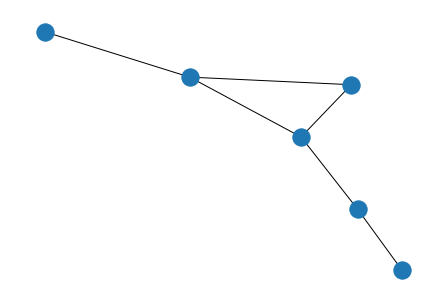

In [4]:
# ground-truth second layer
nx.draw(Gg)

In [50]:
G0 = U.from_networkx(G)
edge_index = G0.edge_index
avg = torch.tensor(colors,dtype=torch.float32) 
f = torch.normal(mean=avg,std=0.2)
G0.x = f[:,None] # feature_size = 1
x = G0.x

In [51]:
edge_score = compute_distance_score(p_norm=1, normalize = False, edge_index = edge_index, x=x)
print(edge_score)
print(edge_index)

Wrong type of normalize, use softmax as default
tensor([0.5037, 5.3613, 0.5037, 0.5931, 0.5931, 0.5359, 0.8347, 2.6973, 0.5359,
        1.0446, 1.0446, 0.7488, 3.2989, 0.7488, 0.5748, 4.5285, 0.8347, 0.5748,
        0.8789, 0.5401, 0.5703, 0.8789, 0.8389, 0.8086, 0.5401, 0.8389, 0.5303,
        2.8216, 0.5703, 0.8086, 0.5303, 1.0354, 1.0056, 0.5719, 0.8316, 3.0021,
        1.0354, 0.9635, 0.5298, 0.7037, 0.5719, 0.9635, 0.9337, 1.0056, 0.5298,
        0.9337, 2.6973, 0.8316, 0.7037, 0.5410, 0.7157, 0.9811, 0.6235, 0.5410,
        0.9401, 0.6747, 0.5825, 0.9811, 0.9401, 0.7653, 3.2989, 0.7157, 0.6747,
        0.7653, 2.8216, 0.6235, 0.5825, 4.5285, 1.0519, 0.7161, 0.5829, 0.5794,
        1.0519, 0.9647, 0.9690, 0.9725, 0.9647, 0.6289, 0.5043, 0.5078, 0.7161,
        0.6289, 0.6332, 0.6367, 0.5829, 0.9690, 0.5043, 0.6332, 5.3613, 3.0021,
        0.5794, 0.9725, 0.5078, 0.6367])
tensor([[ 0,  0,  1,  1,  2,  3,  3,  3,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  

In [52]:
selected_assignment_matrix, selected_node_score_matrix = cluster_assignment(edge_score, edge_index, upper_bound=4, greedy=False, select=True)
selected_assignment_matrix.shape

torch.Size([6, 28])

In [53]:
adj = U.to_dense_adj(edge_index)[0]
adj_new = torch.matmul(torch.matmul(selected_assignment_matrix,adj),selected_assignment_matrix.t()) # connectivity relationship
adj_new[adj_new>0] = 1
edge_index_new = U.remove_self_loops(U.dense_to_sparse(adj_new)[0])[0]
edge_index_new

tensor([[0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 5],
        [2, 3, 5, 3, 4, 0, 3, 0, 1, 2, 1, 0]])

In [54]:
x_new = torch.matmul(selected_node_score_matrix, x)
x_new

tensor([[16.5444],
        [10.5302],
        [ 7.6241],
        [ 2.5965],
        [ 3.2796],
        [ 0.3067]])

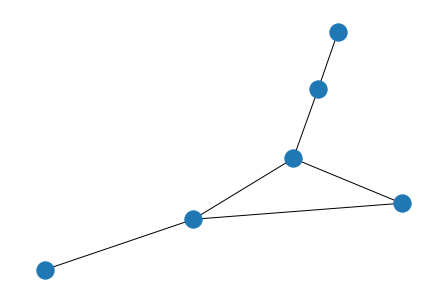

In [55]:
data = Data(x=x_new, edge_index=edge_index_new)
G_new = U.to_networkx(data, to_undirected=True)
nx.draw(G_new)